In [2]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/'

Mounted at /content/drive


In [ ]:
df = pd.read_pickle(folder_path + "/Dataset/dav/result_df_clean.pkl")
# df = pd.read_csv(folder_path + 'Dataset/encrypted_merge.csv')

# Daftar Fungsi Preprocessing


---

Tahapan Preprocessing:

*   remove trail dan head space
*   remove double space
*   remove RT dan RE
*   remove mention
*   remove links
*   remove weird sign
*   unescape html
*   case folding
*   remove punctuations
*   remove digit 2 di akhir kata
*   replace alay dan gaul
*   remove stopwords
*   replace 1 2 3
*   remove digits



In [3]:
!pip install spacy -q

In [4]:
!pip install wordcloud -q

In [5]:
!pip install openpyxl -q

In [6]:
import string
import html
import re
import pickle

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.blank('id')

In [7]:
def remove_double_space(text):
  return re.sub(r'\s+', ' ', text)

def remove_rt_re(text):
  text = text.strip()
  extra_info_pattern = r'\[RE\s+\w+\]'

  try:
    if text[0] == 'R' and text[1] == 'T':
      text = text[2:]
    if text[-1] == ']':
      text = re.sub(extra_info_pattern, ' ', text)
  except:
    pass

  return text.strip()

def remove_mention(text):
  mention_pattern = r'@\S+'
  return re.sub(mention_pattern, ' ', text)

def remove_links(text):
  link_pattern = r'https?://\S+'
  return re.sub(link_pattern, ' ', text)

# Define a function to replace _x008f_ with its corresponding emoji
def replace_emoji(match):
  # Get the matched pattern
  match_str = match.group(1)  # We capture only the hexadecimal part
  # Convert the matched pattern to its corresponding emoji
  return chr(int(match_str, 16))

def remove_weird_sign(text):
  text = re.sub(r'_x([0-9a-fA-F]{4})_', replace_emoji, text)
  text = text.encode("ascii", "ignore").decode()
  return text

# #IndonesiaHijau -> # Indonesia Hijau
def tokenize_spacy(text):
  return nlp(text)

def reconstruct(tokens):
  tokenized_text = [(token.text, token.whitespace_) for token in tokens]
  original_text = "".join([text + whitespace for text, whitespace in tokenized_text])
  return original_text

def unescape_html(text):
  return html.unescape(text)

def case_folding(text):
  return text.lower()

def remove_punctuation(text):
  punctuation_pattern = r'[^\w\s]'
  text_without_punctuation = re.sub(punctuation_pattern, ' ', text)
  return text_without_punctuation

def remove_2_last_string(text):
  doc = nlp(text)
  new_doc = []

  for idx, token in enumerate(doc):
    if token.text[-1] == '2':
      if token.whitespace_:
        temp_doc = nlp.make_doc(str(token.text[:-1]) + ' ')
      else:
        temp_doc = nlp.make_doc(str(token.text[:-1]))
      for tok in temp_doc:
        new_doc.append(tok)
      flag = False
    else:
      new_doc.append(token)

  return reconstruct(new_doc)

def remove_digits(text):
  return re.sub(r'\d', '', text)

In [8]:
alay_df = pd.read_csv(folder_path + 'Dataset/file pendukung/colloquial-indonesian-lexicon.csv')
alay_dict = alay_df.set_index('slang')['formal'].to_dict()

gaul_df = pd.read_csv(folder_path + 'Dataset/file pendukung/kata_gaul.csv')
gaul_df.dropna(inplace=True)
gaul_dict = gaul_df.set_index('gaul')['formal'].to_dict()

set1 = set(alay_dict.keys())
set2 = set(gaul_dict.keys())

duplicates = list(set1.intersection(set2))

for dup in duplicates:
  print(f"Duplikat key: {dup}")
  print(f"kamu gaul: {gaul_dict[dup]}")
  print(f"kamu alay: {alay_dict[dup]}\n")

# remove duplicates
print(f"BEFORE: {len(alay_dict)} : {len(gaul_dict)}")
alay_dict = {k: v for k, v in alay_dict.items() if k not in duplicates}
gaul_dict = {k: v for k, v in gaul_dict.items() if k not in duplicates}
print(f"AFTER: {len(alay_dict)} : {len(gaul_dict)}")

# merge dictionary
add_dict = {
    'nt': 'nice try',
    'gg': 'good game',
    'cd': 'celana dalam',
    'tw': 'trigger warning',
    'cw': 'cewek'
}

merge_dict = {**alay_dict, **gaul_dict, **add_dict}
print(f"\nUKURAN AKHIR: {len(merge_dict)}")

def kamus_alay_gaul(text):
  doc = nlp(text)
  new_doc = []

  for idx, token in enumerate(doc):
    if token.text in merge_dict.keys():
      if token.whitespace_:
        temp_doc = nlp.make_doc(merge_dict[token.text] + ' ')
      else:
        temp_doc = nlp.make_doc(merge_dict[token.text])
      for tok in temp_doc:
        new_doc.append(tok)

    else:
      new_doc.append(token)
  return reconstruct(new_doc)

print("\n=== HASIL UJI COBA ===")
sample_text = "woww woww keren banget dech, met tidur beb. ava mu bagus wah. nt deh."
kamus_alay_gaul(sample_text)

Duplikat key: tw
kamu gaul: trigger warning
kamu alay: tau

Duplikat key: cw
kamu gaul: currently watch
kamu alay: cewek

Duplikat key: nt
kamu gaul: nice try
kamu alay: nanti

Duplikat key: cd
kamu gaul: cool down
kamu alay: celana dalam

Duplikat key: gg
kamu gaul: good game
kamu alay: enggak

BEFORE: 4331 : 61
AFTER: 4326 : 56

UKURAN AKHIR: 4387

=== HASIL UJI COBA ===


'wow wow keren banget deh, selamat tidur beb. profil mu bagus wah. nice try deh.'

In [9]:
# Baca Hasil Label manual digit huruf
gsheetkey = "1NvTocV9MyL8ARoPmRkB4IwHM2Sja-PDctp8aPj0fARQ"
sheet_name = 'data'
url=f'https://docs.google.com/spreadsheet/ccc?key=1NvTocV9MyL8ARoPmRkB4IwHM2Sja-PDctp8aPj0fARQ&output=xlsx'
manual_df = pd.read_excel(url,sheet_name=sheet_name)
manual_df.dropna(inplace=True, ignore_index=True)
manual_dict = manual_df.set_index('kata')['manual'].to_dict()

def replace_1_2_3(text):
  doc = nlp(text)
  new_doc = []

  for idx, token in enumerate(doc):
    if token.text in manual_dict.keys():
      if token.whitespace_:
        temp_doc = nlp.make_doc(manual_dict[token.text] + ' ')
      else:
        temp_doc = nlp.make_doc(manual_dict[token.text])
      for tok in temp_doc:
        new_doc.append(tok)

    else:
      new_doc.append(token)
  return reconstruct(new_doc)

print("=== HASIL UJI COBA ===")
print(replace_1_2_3("saya yakin ganjar L3bihBaik pasti m3nang"))

=== HASIL UJI COBA ===
saya yakin ganjar LebihBaik pasti menang


In [10]:
!pip install sastrawi -q
!pip install nltk -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


In [11]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
list_stopwords_sastrawi = factory.get_stop_words()
sw_indonesia = stopwords.words("indonesian")
sw_inggris = stopwords.words("english")

f = open(folder_path + "Dataset/file pendukung/tala-stopwords-indonesia.txt", "r")
tala_stopwords = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    tala_stopwords.append(line_list[0])
f.close()

custom_stopwords = ['indonesia', 'anies', 'baswedan', 'muhaimin', 'iskandar', 'prabowo', 'subianto', 'gibran', 'rakabuming', 'raka', 'ganjar',
                    'pranowo', 'mahfud', 'amin', 'beswedan', 'nies', 'ahnies', 'abahswedan', 'amin', 'imin', 'chainmin', 'cak',
                    'prab', 'pragi', 'pragib', 'ps', 'pbowogbran', 'prbwo', 'wowo', 'bowo', 'pragi', 'pragib',
                    'gbran', 'pbowogbran', 'gajar', 'md', 'mahmud', 'mahduf']

list_all_stopwords = list_stopwords_sastrawi + sw_indonesia + sw_inggris + tala_stopwords + custom_stopwords
print(len(list_all_stopwords))

def remove_stopwords(text):
  hasil = []
  for word in text.split():
    if word in list_all_stopwords:
      hasil.append('')
    else:
      hasil.append(word)

  return (" ".join(hasil))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


1859


In [12]:
def create_wc(text, title):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(title, fontsize=20)
  plt.show()

In [13]:
def extract_hashtags(text):
  hashtag_pattern = r"#\w+"
  hashtags = re.findall(hashtag_pattern, text)
  return hashtags

def remove_hashtags(text):
  mention_pattern = r'#\S+'
  return re.sub(mention_pattern, ' ', text)

def remove_unuse_hashtag(hashtags):
  pass

def split_hashtag_indonesia(hashtags):
  pass

def split_camel_case(string):
  words = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', string)
  return ' '.join(words)

example = ['#L3bihbaik', '#MahfudLebihBaik3', '#GanjarMahfud2024', '#IndonesiaSentris']
print(remove_unuse_hashtag(example))
print(split_hashtag_indonesia(example))
print(split_camel_case(example[0]))

None
None
bihbaik


# Implementasi Step 1 Preprocessing

In [ ]:
example = "RT Udah @dasndqwhqemoqwjexqpweeqw= deg-degan ya Pak ð #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 https://t.co/0pBJ67AKhE [RE aniesmania]"
print(example)

example = unescape_html(example)
print(example)

example = remove_weird_sign(example)
print(example)

example = remove_mention(example)
print(example)

example = remove_links(example)
print(example)

example = remove_rt_re(example)
print(example)

example = remove_double_space(example)
example = example.strip()
print(example)

RT Udah @dasndqwhqemoqwjexqpweeqw= deg-degan ya Pak ð #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 https://t.co/0pBJ67AKhE [RE aniesmania]
RT Udah @dasndqwhqemoqwjexqpweeqw= deg-degan ya Pak ð #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 https://t.co/0pBJ67AKhE [RE aniesmania]
RT Udah @dasndqwhqemoqwjexqpweeqw= deg-degan ya Pak  #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 https://t.co/0pBJ67AKhE [RE aniesmania]
RT Udah   deg-degan ya Pak  #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 https://t.co/0pBJ67AKhE [RE aniesmania]
RT Udah   deg-degan ya Pak  #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1   [RE aniesmania]
Udah   deg-degan ya Pak  #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1
Udah deg-degan ya Pak #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMena

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [ ]:
nama_re = []
for ind, row in df.iterrows():
  if row['tcode'] == 'rt':
    tweet_rt = row['content'].strip()
    temp = tweet_rt.split('[RE ')[-1]
    temp = temp[:-1]
    nama_re.append(temp)
  else:
    nama_re.append('-')

df['nama_re'] = nama_re
df

,created_at,username,tcode,num_retweets,type,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,content,lang,nama_re
0,2024-01-04 09:57:09+00:00,@QOS7XYPBfXZWFeLSmdLEt8njUMwwr2Fpel3Cqvh2gW4=,rt,1248,twit,266.0,107.0,9687.0,NaN,0.0,RT K-Popers Berencana Kirim Food Truck untuk A...,id,tempodotco
1,2024-01-04 09:57:09+00:00,@lSDenDKpcZVnv9txjBcg5qaqxYgVAq/3gTvA8yxPuL4=,rt,195,twit,564.0,303.0,12461.0,indonesia kaya,2.0,RT Bapak Pendeta Yusak ini Dari Magetan ke Pon...,id,Yurissa_Samosir
2,2024-01-04 09:57:10+00:00,@Ykjdr3xs5+WfH9zBQMoAx5fdTeAwmRRm28PFVw5JeJE=,rt,116,twit,376.0,156.0,7488.0,Indonesia,1.0,"RT Viral , Gimana Mak Mak di jakarta tidak ter...",id,STresnowati1
3,2024-01-04 09:57:10+00:00,@KQ/OmqgBG/U/OVkvpqAQYYiAThFGxQBtg3J5Vjp4Glk=,rt,2264,twit,163.0,203.0,2065.0,NaN,0.0,"RT Mendengar Pak Anies disini, rasanya saya su...",id,tomlembong
4,2024-01-04 09:57:11+00:00,@yqECLRUCZgqx8VzEUl430Wj6mfh2SgDYzKwala0bT5o=,rt,1157,twit,1.0,1.0,798.0,NaN,0.0,RT Media Asing Soroti Cara Anies Gaet Pemilih ...,id,CNNIndonesia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9817350,2024-01-06 11:18:04+00:00,@TwCvtXMk0shToRwnuGzJqqc7CnNfKu5Sy2KGxobvrzE=,rt,1496,twit,139.0,30.0,1308.0,NaN,0.0,RT di Cegat Oleh Anak -Anak Milenial dan Anak-...,id,Yurissa_Samosir
9817351,2024-01-06 11:18:04+00:00,@pEX2KVZs+Vknz0IAD1nLk9XL7f+4tUbLI7k5MkUvZz8=,rt,4,twit,473.0,237.0,21617.0,NaN,0.0,"RT APK dari Pusat Tiba, ANIes Kota Solo Berger...",id,kba_news
9817352,2024-01-06 11:18:05+00:00,@KhXOHuWg3rF+tH/IvnVdIKE6gkQoU5+CqePqmIFFrQg=,rt,151,twit,143.0,56.0,2932.0,NaN,0.0,RT Tetap semangat pak @kYo4g8BWrOVt8nzENmM18Ff...,id,TheLadyJoker
9817353,2024-01-06 11:18:06+00:00,@aAJ+fus0G60OSVYs5r2RVSwp90Lb7qwwNnUQmiE0cIY=,rt,996,twit,337.0,208.0,26490.0,NaN,0.0,RT Saya mau cari hadiah untuk mas Anies topi s...,id,cakimiNOW


In [ ]:
df['clean_content'] = [unescape_html(data) for data in df['content']]
df['clean_content'] = [remove_weird_sign(data) for data in df['clean_content']]
df['clean_content'] = [remove_mention(data) for data in df['clean_content']]
df['clean_content'] = [remove_links(data) for data in df['clean_content']]
df['clean_content'] = [remove_rt_re(data) for data in df['clean_content']]
df['clean_content'] = [remove_double_space(data) for data in df['clean_content']]
df['clean_content'] = [data.strip() for data in df['clean_content']]
df['clean_content'].iloc[100]

'*Ternyata Anies lebih gila.. share ke semua group agar kita semua bangga menjadi Anak bangsa Indonesia.... *Penuh Prestasi, bukan karya abal"*'

In [ ]:
# df.to_pickle(folder_path + 'Dataset_Part2/surya_prep_step1_not_dropped.pkl')

In [ ]:
df.drop_duplicates(subset='clean_content').shape

(1827983, 14)

In [ ]:
columns_to_fill_numerical = ['num_retweets', 'frn_cnt', 'flw_cnt', 'sts_cnt', 'lst_cnt']
df[columns_to_fill_numerical] = df[columns_to_fill_numerical].fillna(0)  # Use 'ffill' or other methods as needed

columns_to_fill_string = ['username', 'type', 'loc', 'lang']
df[columns_to_fill_string] = df[columns_to_fill_string].fillna('-')  # Use 'ffill' or other methods as needed

In [ ]:
import pandas as pd

def get_mode(series):
  return series.mode()[0]

# Group by 'content' and aggregate
result_df = df.groupby('clean_content').agg(
    created_at=('created_at', 'max'),
    username=('username', 'first'),
    tcode=('tcode', 'first'),
    num_retweets=('num_retweets', 'max'),
    frn_cnt=('frn_cnt', 'mean'),
    flw_cnt=('flw_cnt', 'mean'),
    sts_cnt=('sts_cnt', 'mean'),
    loc=('loc', get_mode),
    lst_cnt=('lst_cnt', 'mean'),
    lang=('lang', get_mode),
    appearance_count=('clean_content', 'size'),
    nama_re=('nama_re', 'first')
).reset_index()

result_df

,clean_content,created_at,username,tcode,num_retweets,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,lang,appearance_count,nama_re
0,,2024-01-31 17:56:21+00:00,@/YVOFjESEAVlZxJ6wM0f8jdsaQON7seAYx35rKatQII=,rt,89,1191.691298,2665.492256,22284.476084,-,2.099210,id,16077,RaviAbi51236
1,!,2024-01-29 16:57:00+00:00,@CrGiujGfoU0FSz2fzfvDU6Eog0QiZYSw4iSC+hwGRmQ=,reply,0,429.250000,315.250000,16510.000000,-,0.250000,id,4,-
2,! ! ANIES ROCKS DEBAT CAPRES #Anies2ndStage #H...,2024-01-07 12:24:31+00:00,@yMJ3CsRc91f+At1ynQ8yaxhAJfTmM+ZEZrLFvaUIyeE=,mention,0,77.000000,51.000000,4972.000000,nowhere,0.000000,id,1,-
3,"! ., ( 19-1-2024) Prabowo Ungkap Rasio Utang B...",2024-01-19 07:39:21+00:00,@BPfs4ab7X7evTJWjphZtcq+ajnefXVyTFfREbtJZiu0=,mention,0,3457.000000,2042.000000,36864.000000,Jakarta Pusat,1.000000,id,1,-
4,! ANIES ROCKS DEBAT CAPRES #Anies2ndStage #Hwa...,2024-01-07 13:13:15+00:00,@IdZ4MZc55eEC7Vz4XD2I01IqpxjK38IXkF8kXs8ORhk=,rt,3,835.200000,281.100000,13609.200000,-,2.300000,id,10,iamrocket96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827978,"~terharu~ ~semoga pak Anies semakin kuat, dan ...",2024-01-18 11:25:17+00:00,@RLx9MQkPOUtJExiYhq22qzGX5UTPFTCUtusVdzVjhrE=,reply,0,4001.000000,4054.000000,3907.000000,Indonesia,1.000000,id,1,-
1827979,~yg mana itu bisa menjadi blunder buat pak ani...,2024-01-10 02:50:15+00:00,@5dYr5xgQ3z8UoRGu4XVPbyz5mEZTL2pvUkglHBnHB14=,reply,0,114.000000,45.000000,1079.000000,-,0.000000,id,1,-
1827980,~~~ !! ANIES ROCKS DEBAT CAPRES #Anies2ndStage...,2024-01-07 11:51:15+00:00,@Dyj3VS+tKBN99xSAwhGI1y6csRjb0a4KXlillEZP7R0=,reply,0,627.000000,534.000000,25003.000000,-,1.000000,id,1,-
1827981,~~~ GANJAR SOSOK PEMIMPIN JAMAN NOW ~~~ Pemimp...,2024-01-07 15:57:52+00:00,@VgjlmlhJmOs5VrBDLAHiraEPtNJedAINBLP6H/fZV40=,rt,41,6412.622222,11010.666667,69181.088889,-,2.266667,id,45,denni_sauya


In [ ]:
# result_df.to_pickle(folder_path + 'Dataset_Part2/surya_prep_step1_dropped.pkl')

# Implementasi Preprocessing Topic Modeling

---


Urutan Preprocessing:
* Unescape HTML, remove weird sign
* Penghapusan mention, link -> drop duplicates (pengambilan fitur berapa * duplikasi teks untuk fitur non tweet)
* remove re rt
* Replace 1 2 3
* Remove hashtag yang tidak diinginkan (berkaitan dengan paslon secara langsung) (hashtag keyword ‘indonesia’ di split saja) #indonesiasentris -> [#, sentris]
* Pemisahan hashtag
* Kamus alay dan gaul
* Remove stopwords
* Remove digit
* Remove tanda baca
* Remove double space dan strip
* Tambah stopwords (iterasi sampai puas) -> remove stopwords

Proses 3 dilakukan secara berulang sampai sekiranya stopwords udah masuk semua


## Step 1

In [ ]:
# example = "RT Udah @dasndqwhqemoqwjexqpweeqw= deg-degan ya Pak ð #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 https://t.co/0pBJ67AKhE [RE aniesmania]"
# print(example)

# example = remove_mention(example)
# print(example)

# example = remove_links(example)
# print(example)

# example = remove_double_space(example)
# example = example.strip()
# print(example)

RT Udah @dasndqwhqemoqwjexqpweeqw= deg-degan ya Pak ð #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 https://t.co/0pBJ67AKhE [RE aniesmania]
RT Udah   deg-degan ya Pak ð #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 https://t.co/0pBJ67AKhE [RE aniesmania]
RT Udah   deg-degan ya Pak ð #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1   [RE aniesmania]
RT Udah deg-degan ya Pak ð #update #inspirasi #anies #amin #AniesMuhaimin2024 #AminMenang1Putaran #CoblosNo1 [RE aniesmania]


In [ ]:
# df['content'] = [remove_mention(data) for data in df['content']]
# df['content'] = [remove_links(data) for data in df['content']]
# df['content'] = [remove_double_space(data) for data in df['content']]
# df['content'] = [data.strip() for data in df['content']]
# df['content'].iloc[100]

'RT *Ternyata Anies lebih gila.. share ke semua group agar kita semua bangga menjadi Anak bangsa Indonesia.... *Penuh Prestasi, bukan karya abal"* [RE Andria75777]'

In [ ]:
# df.to_pickle(folder_path + 'Dataset/surya_prep_step1.pkl')

## Step 2

In [ ]:
df = pd.read_pickle(folder_path + "/Dataset/dav/result_df_clean_surya.pkl")
df

,content,real_content,created_at,username,tcode,num_retweets,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,lang,appearance_count,nama_re,hashtags,content_surya,content_tm
0,,@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...,2024-01-31 17:26:28+00:00,@be9+Qm5EsBY7VLxMEGgBlOYaT0KrMsiQQLzN5iG2hOY=,reply,36,696.150781,1543.289555,14114.732016,-,1.757412,id,9411,-,[],@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...,@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...
1,!,@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...,2024-01-29 16:57:00+00:00,@JVWxyA2fM/S2B0bN/n/buYbHxNqUC91UUX6ShBzub+I=,reply,0,327.000000,208.666667,11230.333333,-,0.000000,id,3,-,[],@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...,@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...
2,! deretan pesohor dan selebriti yang dukung ga...,! Deretan Pesohor dan Selebriti yang Dukung Ga...,2024-01-30 02:03:42+00:00,@7jB3OiFFcymo1DxD4GO8wR2tuWnQLk+nRHfZmLs1iHo=,mention,0,28.000000,2.000000,75.000000,Indonesia,0.000000,id,1,-,"[#GanjarMahfud2024, #Kopassos03, #GanjarPresid...",! Deretan Pesohor dan Selebriti yang Dukung Ga...,! Deretan Pesohor dan Selebriti yang Dukung Ga...
3,!! iya pakk salah strategii next nya di perbai...,@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...,2024-01-07 15:57:19+00:00,@CDJsmOeil3IHVzBWFKLBs21n0Q2nBvRird0Wb9yxync=,reply,0,2.000000,2.000000,234.000000,-,0.000000,id,1,-,[],@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...,@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...
4,!! katanya sudah dikembalikan oleh !!,@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...,2024-01-19 04:19:17+00:00,@X4DJ8WnurWZZIm9IizCEzcdSPvFwGF1pnHnLk1YMgWk=,reply,0,1347.000000,1390.000000,60962.000000,-,0.000000,id,1,-,[],@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...,@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161194,ùùù ùúªùø±ùùùø§ ùùù ùúªùø±ù ø§ùù...,ÙÙÙ ÙÚªÙØ±ÙÙÙØ§ ÙÙÙ ÙÚªÙØ±Ù Ø§ÙÙ...,2024-01-23 19:33:56+00:00,@YlUZ3ZhBsq0qbJW78fvg+NQa9XAwlZc4Td3UlJnX9VM=,reply,0,817.000000,214.000000,804.000000,Semarang Jawa Tengah,0.000000,id,1,-,[],ÙÙÙ ÙÚªÙØ±ÙÙÙØ§ ÙÙÙ ÙÚªÙØ±Ù Ø§ÙÙ...,Dan mereka (orang-orang kafir) membuat tipu da...
2161195,ùø§ ø§ùùù ùø§ ø±ø¨ lihatlah pak anies ..p...,@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...,2024-01-05 08:07:21+00:00,@L6SfnSmUwh00lMBvj0JM+1MAFGNyHoDgNsZFTsGSPrg=,reply,0,755.000000,376.000000,6844.000000,-,0.000000,id,1,-,[],@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...,@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...
2161196,ùø§ù ùùùùùùø·ùùù ùø§ù ùùùùùù...,ÙØ§Ù ÙÙÙÙÙÙØ·ÙÙÙ ÙØ§Ù ÙÙÙÙÙÙ...,2024-01-28 23:46:18+00:00,@2kSMZAr8Of/TLnCFHP74tuRyrjGH5zTSj8Cg8xVSPd4=,mention,0,21.000000,54.000000,1279.000000,"Riau, Indonesia",0.000000,id,1,-,[],ÙØ§Ù ÙÙÙÙÙÙØ·ÙÙÙ ÙØ§Ù ÙÙÙÙÙÙ...,. 2024 Indonesia Maju Bpk. Anies-Muhaimin
2161197,ùø±ùø¯ù ø§ùùù øªø¨ø§ø±ù ùøªø¹ø§ùù ù...,@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...,2024-01-21 23:32:46+00:00,@39Pxegm8y2KaJWoGqZHOF05wmueMui4u2yP8EaaK2YM=,reply,0,120.000000,73.000000,791.000000,"Sukasari, Indonesia",0.000000,id,1,-,[],@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...,@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...


In [ ]:
df.drop(columns='content_tm', axis=1, inplace=True)

In [ ]:
df['num_words'] = [len(data.split()) for data in df['content_surya']]

print(df[df['num_words'] == 0].shape[0])
print(df[df['num_words'] == 1].shape[0])
print(df[df['num_words'] == 2].shape[0])

67
305
1343


In [ ]:
df.drop(columns='num_words', axis=1, inplace=True)

### Preprocessing Teks Twit

In [ ]:
df['content_tm'] = [replace_1_2_3(data) for data in df['content_surya']]
df['content_tm'] = [remove_rt_re(data) for data in df['content_tm']]
df['content_tm'] = [data.lower() for data in df['content_tm']]
df['content_tm'] = [remove_mention(data) for data in df['content_tm']]
df['content_tm'] = [remove_links(data) for data in df['content_tm']]
df['content_tm'] = [unescape_html(data) for data in df['content_tm']]
df['content_tm'] = [remove_weird_sign(data) for data in df['content_tm']]
df['content_tm'] = [kamus_alay_gaul(data) for data in df['content_tm']]
df['content_tm'] = [remove_punctuation(data) for data in df['content_tm']]
df['content_tm'] = [remove_stopwords(data) for data in df['content_tm']]
df['content_tm'] = [remove_digits(data) for data in df['content_tm']]
df['content_tm'] = [remove_double_space(data) for data in df['content_tm']]
df['content_tm'] = [data.strip() for data in df['content_tm']]
df['content_tm'].iloc[331]

'surprise anak alam hebat uang saku posyandu'

In [ ]:
df.to_pickle(folder_path + 'Dataset_Part2/result_df_clean_tm.pkl')

### Preprocessing Hashtag


---


1. Cek apakah termasuk hashtag yang harus diabaikan (berdasarkan daftar)
2. split hashtag berdasarkan dictionary
3. split hashtag dengan fungsi
4. remove indonesia
5. remove hashtag yang mengandung keyword paslon

In [ ]:
df = pd.read_pickle(folder_path + 'Dataset_Part2/result_df_clean_tm_last_iteration.pkl')

In [41]:
hashtag_paslon1_manual = pd.read_excel(folder_path + 'Dataset_Part2/keyterms_paslon/hashtag_paslon1.xlsx')
hashtag_paslon1_manual = hashtag_paslon1_manual.head(200)
hashtag_paslon1_manual = hashtag_paslon1_manual[hashtag_paslon1_manual['Label'].isna()]

hashtag_paslon2_manual = pd.read_excel(folder_path + 'Dataset_Part2/keyterms_paslon/hashtag_paslon2.xlsx')
hashtag_paslon2_manual = hashtag_paslon2_manual.head(200)
hashtag_paslon2_manual = hashtag_paslon2_manual[hashtag_paslon2_manual['Label'].isna()]

hashtag_paslon3_manual = pd.read_excel(folder_path + 'Dataset_Part2/keyterms_paslon/hashtag_paslon3.xlsx')
hashtag_paslon3_manual = hashtag_paslon3_manual.head(200)
hashtag_paslon3_manual = hashtag_paslon3_manual[hashtag_paslon3_manual['Label'].isna()]

In [ ]:
hashtag_paslon1_manual

,Unnamed: 0,hashtag,count,Label
0,0,#AMINAjaDulu,398879,NaN
1,1,#AniesMuhaimin2024,134312,NaN
2,2,#DesakAnies,85963,NaN
3,3,#HaveAniesDay,70925,NaN
4,4,#PahitManiesAlwaysWithAnies,70448,NaN
...,...,...,...,...
194,194,#DukungGibranCoblosImin,139,NaN
195,195,#AnieMuhaimin2024,139,NaN
196,196,#Anies2ndstage,134,NaN
197,197,#AminMenangJudolHilang,132,NaN


In [ ]:
all_ignore_hashtag = list(hashtag_paslon1_manual['hashtag']) + list(hashtag_paslon2_manual['hashtag']) + list(hashtag_paslon3_manual['hashtag'])
all_ignore_hashtag = [data.lower() for data in all_ignore_hashtag]
print(len(all_ignore_hashtag))

529


In [ ]:
hashtag_split_df = pd.read_pickle(folder_path + 'Dataset_Part2/df_hashtag_split.pkl')
hashtag_split_dict = dict(zip(hashtag_split_df['lower_case'], hashtag_split_df['hasil_split']))

hashtag_split_df

,asli,hasil_split,lower_case,num_splits
0,#Ù,,#ù,0
1,#ØºØ²Ù,,#øºø²ù,0
2,#ØµØ,,#øµø,0
3,#Ø²Ø,,#ø²ø,0
4,#Ø,,#ø,0
...,...,...,...,...
22982,#01AMIN,AMIN,#01amin,4
22983,#01AduDomba,Adu Domba,#01adudomba,9
22984,#0103AklamasiPerubahan,Aklamasi Perubahan,#0103aklamasiperubahan,18
22985,#01,,#01,0


In [ ]:
topic_modeling_stopwords = ['anies', 'baswedan', 'muhaimin', 'iskandar', 'prabowo', 'subianto', 'gibran', 'rakabuming', 'raka', 'ganjar',
                    'pranowo', 'mahfud', 'amin', 'beswedan', 'nies', 'ahnies', 'abahswedan', 'amin', 'imin', 'chainmin', 'cak',
                    'prab', 'pragi', 'ps', 'pbowogbran', 'prbwo', 'wowo', 'bowo', 'pragib',
                    'gbran', 'pbowogbran', 'gajar', 'md', 'mahmud', 'mahduf', 'gm', 'park', 'ahn', 'prabowogibran', 'cha']

In [ ]:
def split_dictionary(hashtag):
  return hashtag_split_dict[hashtag]

def split_camel_case(hashtag):
  words = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', hashtag)
  return ' '.join(words)

with open(folder_path + 'Dataset_Part2/surya/stopwords_all_iterasi.pkl', 'rb') as f:
  custom_stopwords = pickle.load(f)

def preprocessing_hashtag(hashtag):
  temp = []

  if hashtag.lower() not in all_ignore_hashtag:
    hasil = ''
    try:
      hasil = split_dictionary(hashtag)
    except:
      hasil =  split_camel_case(hashtag)

    for word in hasil.split():
      if word.lower() in topic_modeling_stopwords:
        temp = []
        break
      elif word.lower() not in custom_stopwords:
        temp.append(word)

  return ' '.join(temp)

print('hasil preprocessing:', preprocessing_hashtag('#DukungGibranCoblosImin'))
print('hasil preprocessing:', preprocessing_hashtag('#dukunggibrancoblosimin'))
print('hasil preprocessing:', preprocessing_hashtag('#CoblosCoblosAniessss'))
print('hasil preprocessing:', preprocessing_hashtag('#GanjarMahfud2024'))
print('hasil preprocessing:', preprocessing_hashtag('#DavianBENITO'))
print('hasil preprocessing:', preprocessing_hashtag('#L3bihbaik'))
print('hasil preprocessing:', preprocessing_hashtag('#BisaAnies'))
print('hasil preprocessing:', preprocessing_hashtag('#jakartaIndoGanjarnesia'))
print('hasil preprocessing:', preprocessing_hashtag('#indonesiasentris'))
print('hasil preprocessing:', preprocessing_hashtag('#indonesiaSentris'))
print('hasil preprocessing:', preprocessing_hashtag('#IndonesiaSentris'))
print('hasil preprocessing:', preprocessing_hashtag('#rakyatmakin'))

hasil preprocessing: 
hasil preprocessing: 
hasil preprocessing: Aniessss
hasil preprocessing: 
hasil preprocessing: Davian BENITO
hasil preprocessing: bihbaik
hasil preprocessing: 
hasil preprocessing: jakarta Indo Ganjarnesia
hasil preprocessing: Sentris
hasil preprocessing: Sentris
hasil preprocessing: Sentris
hasil preprocessing: 


In [ ]:
df['hashtags_clean'] = [[preprocessing_hashtag(data) for data in data_list] for data_list in df['hashtags']]
df['hashtags_clean']

0                        []
1                        []
2          [, Kopassos, , ]
3                        []
4                        []
                 ...       
2161194                  []
2161195                  []
2161196                  []
2161197                  []
2161198                  []
Name: hashtags_clean, Length: 2161199, dtype: object

In [ ]:
df.to_pickle(folder_path + 'Dataset_Part2/result_df_clean_tm.pkl')

## Step 3

In [ ]:
df = pd.read_pickle(folder_path + 'Dataset_Part2/result_df_clean_tm.pkl')

In [ ]:
df['real_content'].iloc[1184328]

'@zN6g4wwYbcuA+fMTidjUNVuKWCRjtMEfScSJEPkJKfw= @eyQS/3fNyOgfxwA2g59iXKEZbfbUFNXQaA5a9JkHwYE= Nyata sekali, RakyatSmakin MASbowoGIbran adalah panutan yg membuat tujuannya dan menunjukkan jalannya untuk kesejahteraan negara. #Cuma02HatinyaTulus RakyatIngin SejukDamai @/NBdRwSth4SnFsfhQZDo8sHiQoKDYY/NnOg3BLKQG4A= @Xw1kfhlJ9UXpJYLH7E/EBz6k7Qwg34c4naecbOF57kg= https://t.co/s9DGj2UCvd'

In [ ]:
for idx, data in enumerate(df['content_tm']):
  if 'ahn nice' in data.lower():
    print(idx)
    print(data)

Streaming output truncated to the last 5000 lines.
863924
kayaknya sih ktp angin belajar politik drama korea deh penuh retorika omong kosong park ahn nice kpopers bubble abah
863926
kayaknya sih ktp angin puas bikin chaos jakarta park ahn nice kpopers politik identitas bubble
863940
kayaknya sih jago bikin janji doang park ahn nice kpopers abah dislepatch cha im
864048
kayaknya wan abud lupa hancurkan jakarta nih park ahn nice kpopers bubble abah
864159
kayanya selektif nih memilih cowok captain park ahn nice kpopers bubble abah
864174
kayanya nih janji faskesnya sibuk tolak ikn park ahn nice kpopers bubble abah
867467
kebanyakan menonton sinetron tuh wan abud ngira negara sinetron belaka park ahn nice kpopers politik identitas bubble abah
867667
terbayang sih kalo presiden ktp angin park ahn nice kpopers politik identitas bubble abah
868321
keberadaannya tim racun merusak park ahn nice kpopers bubble abah
883321
kecewa banget nih janjinya indah realisasinya bikin sakit hati park ahn n

In [ ]:
df['real_content'].iloc[13591]

'#AsalBukanPrabowo #AsalBukan02 ã\x83\x92ã\x82«ã\x83ªã\x82µã\x82¹ #ã\x83¨ã\x83¼ã\x82«ã\x83\x89ã\x83¼ã\x82«ã\x83¬ã\x83¼ã\x83\x95ã\x82§ã\x82¹ ä»\x8aæ°¸ã\x82«ã\x83\x96ã\x82¹ Prabowo OUR MIRACLE GUNWOOK DAY LEE JENO THANK YOU emasindonesia dirampok1t PTN TOP 10 Umur 25 MatPat AyahBOWO AdalahKITA DukunganTulus Untuk02 Ekuador WA DI BIO Anies Gombel Rahasia Starting 2024 Kalbar https://t.co/bGfsH168qt'

In [ ]:
import pickle

full_text = ' '.join(df['content_tm'])

with open(folder_path + 'Dataset/full_text.pkl', 'wb') as f:
  pickle.dump(full_text, f)

In [ ]:
import pickle

with open(folder_path + 'Dataset/full_text.pkl', 'rb') as f:
  full_text = pickle.load(f)

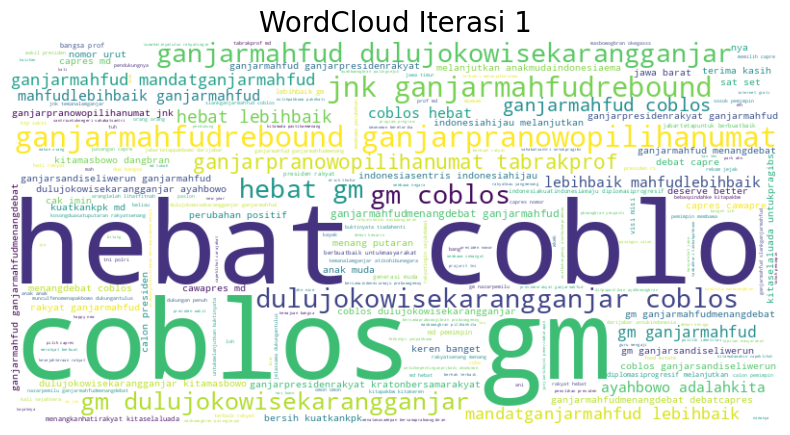

In [ ]:
create_wc(full_text, "WordCloud Iterasi 1")

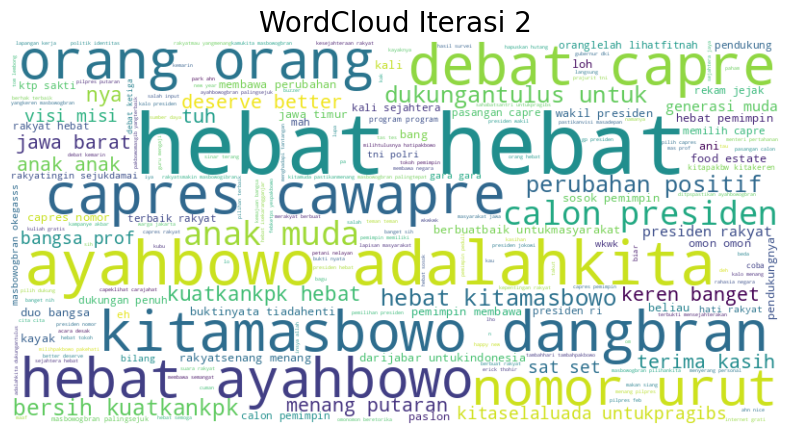

In [ ]:
create_wc(full_text, "WordCloud Iterasi 2")

### Buat dataframe pengecekan kata stopwords (200) / iterasi

In [ ]:
from collections import Counter

words = full_text.split()
word_counts = Counter(words)
top_200_words = word_counts.most_common(331)
print(top_200_words[:10])

[('rakyat', 194805), ('orang', 136964), ('debat', 111824), ('jokowi', 88387), ('program', 77257), ('negara', 70620), ('anak', 66784), ('pilpres', 62879), ('politik', 60351), ('bangsa', 55816)]


In [ ]:
top_words_df = pd.DataFrame(top_200_words)
top_words_df = top_words_df.tail(200)
top_words_df.columns = ['word', 'count']
top_words_df.to_csv(folder_path + 'Dataset_Part2/surya/cek stopwords/iterasi_3.csv', index=False)
top_words_df

,word,count
131,kekuatan,13111
132,gagasan,13033
133,bu,12982
134,butuh,12927
135,buzzer,12902
...,...,...
326,santri,7628
327,bansos,7600
328,mengajak,7549
329,cuman,7544


#### Hasil Iterasi 2

In [ ]:
# gsheetkey = "1y4pBQhPq6e_wJ1LMjFBaaFBufmLv4jBfvL7fvO_-05g"
# sheet_name = 'iterasi_2'
# url=f'https://docs.google.com/spreadsheet/ccc?key={gsheetkey}&output=xlsx'
# iterasi_2 = pd.read_excel(url,sheet_name=sheet_name)
# iterasi_2.dropna(inplace=True, subset='label', ignore_index=True)
# iterasi_2.to_csv(folder_path + 'Dataset_Part2/surya/stopwords_iterasi2.csv', index=False)

In [ ]:
iterasi_2 = pd.read_csv(folder_path + 'Dataset_Part2/surya/stopwords_iterasi2.csv')
iterasi_2

,word,count,label
0,hebat,300169,1.0
1,capres,145992,1.0
2,pemimpin,135905,1.0
3,presiden,128947,1.0
4,banget,115467,1.0
...,...,...,...
64,menangkan,13877,1.0
65,elektabilitas,13322,1.0
66,kasihan,13238,1.0
67,merakyat,13188,1.0


In [ ]:
temp_hasil = []
list_stopwords_2 = list(iterasi_2['word'])

for word in full_text.split():
  if word not in list_stopwords_2:
    temp_hasil.append(word)
full_text2 = ' '.join(temp_hasil)

In [ ]:
with open(folder_path + 'Dataset/full_text_iterasi2.pkl', 'wb') as f:
  pickle.dump(full_text2, f)

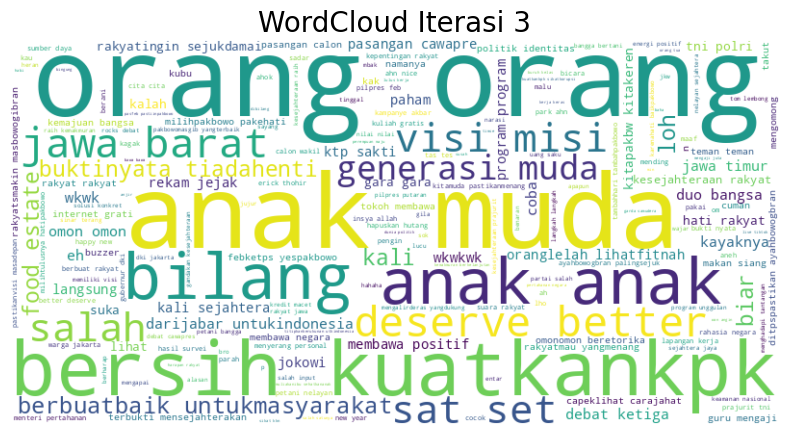

In [ ]:
create_wc(full_text2, "WordCloud Iterasi 3")

#### Hasil Iterasi 3

In [ ]:
gsheetkey = "10UxHDoZ9fosscWXoD1xQgGF95zaLEFSaBvsH5kIcPiE"
sheet_name = 'iterasi_3'
url=f'https://docs.google.com/spreadsheet/ccc?key={gsheetkey}&output=xlsx'
iterasi_3 = pd.read_excel(url,sheet_name=sheet_name)
iterasi_3.dropna(inplace=True, subset='label', ignore_index=True)
iterasi_3.to_csv(folder_path + 'Dataset_Part2/surya/stopwords_iterasi3.csv', index=False)

In [ ]:
iterasi_3 = pd.read_csv(folder_path + 'Dataset_Part2/surya/stopwords_iterasi3.csv')
iterasi_3

,word,count,label
0,bu,12982,1.0
1,better,12870,1.0
2,bro,12690,1.0
3,a,12638,1.0
4,sat,12593,1.0
5,loh,12136,1.0
6,gara,11854,1.0
7,deserve,11559,2.0
8,eh,11192,1.0
9,pengin,11158,1.0


In [ ]:
temp_hasil = []
list_stopwords_3 = list(iterasi_3['word'])

for word in full_text2.split():
  if word not in list_stopwords_3:
    temp_hasil.append(word)
full_text3 = ' '.join(temp_hasil)

In [ ]:
with open(folder_path + 'Dataset/full_text_iterasi3.pkl', 'wb') as f:
  pickle.dump(full_text3, f)

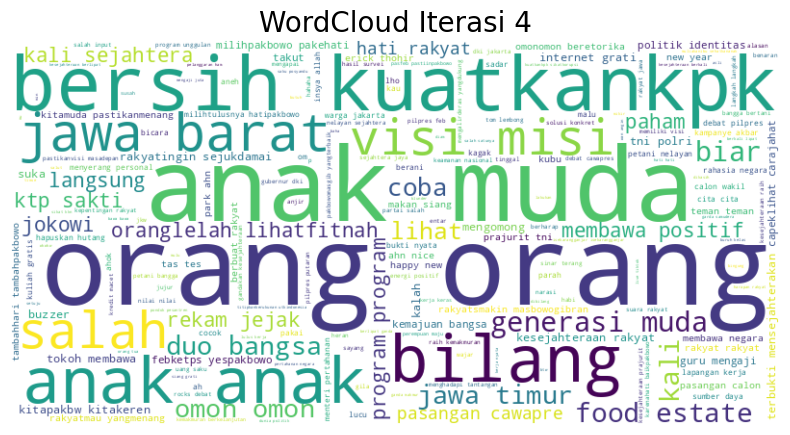

In [ ]:
create_wc(full_text3, "WordCloud Iterasi 4")

#### Hasil Iterasi 4

In [ ]:
stopwords_4 = ['milihpakbowo', 'pakehati', 'febketps', 'yespakbowo', 'kitapakbw', 'kitakeren', 'rakyatmau', 'yangmenang',
 'capeklihat', 'carajahat', 'rakyatmakin', 'masbowogibran', 'tambahhari', 'tambahpakbowo', 'park ahn', 'ahn nice', 'prabowogibran', 'cha im',
 'milihtulusnya', 'hatipakbowo', 'milihpakbowo', 'pakehati', 'kitamuda', 'pastikanmenang', 'oranglelah', 'lihatfitnah', 'yangterbaik',
 'rakyatingin', 'sejukdamai', 'capeklihat', 'carajahat']

In [ ]:
temp_hasil = []

for word in full_text3.split():
  if word not in stopwords_4:
    temp_hasil.append(word)
full_text4 = ' '.join(temp_hasil)

In [ ]:
with open(folder_path + 'Dataset/full_text_iterasi4.pkl', 'wb') as f:
  pickle.dump(full_text4, f)

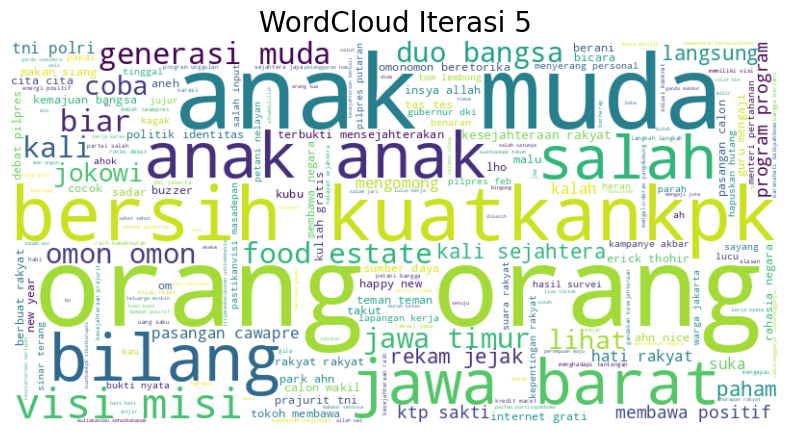

In [ ]:
create_wc(full_text4, "WordCloud Iterasi 5")

### Merge All stopwords

In [14]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
list_stopwords_sastrawi = factory.get_stop_words()
sw_indonesia = stopwords.words("indonesian")
sw_inggris = stopwords.words("english")

f = open(folder_path + "Dataset/file pendukung/tala-stopwords-indonesia.txt", "r")
tala_stopwords = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    tala_stopwords.append(line_list[0])
f.close()

custom_stopwords = ['indonesia', 'anies', 'baswedan', 'muhaimin', 'iskandar', 'prabowo', 'subianto', 'gibran', 'rakabuming', 'raka', 'ganjar',
                    'pranowo', 'mahfud', 'amin', 'beswedan', 'nies', 'ahnies', 'abahswedan', 'amin', 'imin', 'chainmin', 'cak',
                    'prab', 'pragi', 'pragib', 'ps', 'pbowogbran', 'prbwo', 'wowo', 'bowo', 'pragi', 'pragib',
                    'gbran', 'pbowogbran', 'gajar', 'md', 'mahmud', 'mahduf', 'gm']

list_all_stopwords = list_stopwords_sastrawi + sw_indonesia + sw_inggris + tala_stopwords + custom_stopwords

iterasi_2 = pd.read_csv(folder_path + 'Dataset_Part2/surya/stopwords_iterasi2.csv')
list_stopwords_2 = list(iterasi_2['word'])

iterasi_3 = pd.read_csv(folder_path + 'Dataset_Part2/surya/stopwords_iterasi3.csv')
list_stopwords_3 = list(iterasi_3['word'])

list_stopwords_4 = ['milihpakbowo', 'pakehati', 'febketps', 'yespakbowo', 'kitapakbw', 'kitakeren', 'rakyatmau', 'yangmenang',
 'capeklihat', 'carajahat', 'rakyatmakin', 'masbowogibran', 'tambahhari', 'tambahpakbowo', 'park ahn', 'ahn nice', 'prabowogibran', 'cha im',
 'milihtulusnya', 'hatipakbowo', 'milihpakbowo', 'pakehati', 'kitamuda', 'pastikanmenang', 'oranglelah', 'lihatfitnah', 'yangterbaik',
 'rakyatingin', 'sejukdamai', 'capeklihat', 'carajahat', 'coblos', 'orang']

list_all_stopwords = list_all_stopwords + list_stopwords_2 + list_stopwords_3 + list_stopwords_4
print(len(list_all_stopwords))

def remove_stopwords_all(text):
  hasil = []
  for word in text.split():
    if word in list_all_stopwords:
      hasil.append('')
    else:
      hasil.append(word)

  return (" ".join(hasil))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2005


In [ ]:
# with open(folder_path + 'Dataset_Part2/surya/stopwords_all_iterasi.pkl', 'wb') as f:
#   pickle.dump(list_all_stopwords, f)

In [ ]:
df['content_tm_rm_stopwords_last'] = [remove_stopwords_all(data) for data in df['content_tm']]

In [ ]:
df.to_pickle(folder_path + 'Dataset_Part2/result_df_clean_tm_last_iteration.pkl')

In [ ]:
df = pd.read_pickle(folder_path + 'Dataset_Part2/result_df_clean_tm_last_iteration.pkl')

In [ ]:
df.columns

Index(['content', 'real_content', 'created_at', 'username', 'tcode',
       'num_retweets', 'frn_cnt', 'flw_cnt', 'sts_cnt', 'loc', 'lst_cnt',
       'lang', 'appearance_count', 'nama_re', 'hashtags', 'content_surya',
       'content_tm', 'hashtags_clean', 'content_tm_rm_stopwords_last'],
      dtype='object')

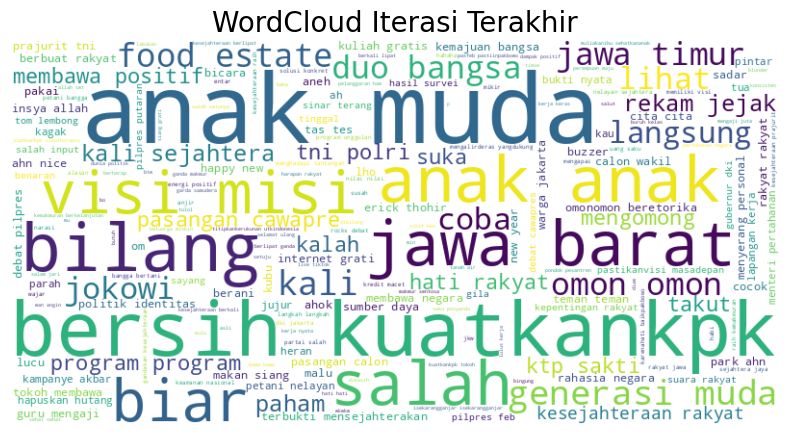

In [ ]:
create_wc(' '.join(df['content_tm_rm_stopwords_last']), "WordCloud Iterasi Terakhir")

# Daftar Hashtag

In [ ]:
import re

def extract_hashtags(text):
  hashtag_pattern = r"#\w+"
  hashtags = re.findall(hashtag_pattern, text)
  return hashtags

extract_hashtags(df['content'].iloc[0])

['#TempoSeleb']

In [ ]:
df['hashtags'] = [extract_hashtags(data) for data in df['content']]

In [ ]:
df['hashtags'].iloc[:10]

0         [#TempoSeleb]
1                    []
2                    []
3                    []
4                    []
5                    []
6    [#MenangSeputaran]
7                    []
8                    []
9    [#MenangSeputaran]
Name: hashtags, dtype: object

In [ ]:
all_hashtags = []

for hashtags in df['hashtags']:
  all_hashtags.extend(hashtags)

print(len(all_hashtags))

In [ ]:
print(len(all_hashtags))
print(len(set(all_hashtags)))

11052520
26808


In [ ]:
from collections import Counter

hashtag_counts = Counter(all_hashtags)

In [ ]:
import pandas as pd

hashtags_df = pd.DataFrame(hashtag_counts.items(), columns=['hashtag', 'count'])
hashtags_df.sort_values(by='count', ascending=False, inplace=True)
hashtags_df

,hashtag,count
121,#JNK,898709
123,#GanjarMahfudRebound,860268
122,#GanjarPranowoPilihanUmat,814906
6,#GanjarMahfud2024,548682
4785,#Coblos3,473240
...,...,...
15440,#Prabowodesakjokowi,1
15429,#bebasaktif,1
15430,#SayNoToPemimpinCengeng,1
15436,#Covid19,1


In [ ]:
# hashtags_df.to_pickle(folder_path + 'Dataset/hashtags_surya.pkl')

In [ ]:
hashtags_dhiwa = pd.read_csv(folder_path + 'Dataset/unique_hashtag.csv')
hashtags_dhiwa

,Unnamed: 0,hashtag,count
0,0,#jnk,897838
1,1,#ganjarmahfudrebound,852349
2,2,#ganjarpranowopilihanumat,814905
3,3,#ganjarmahfud2024,551626
4,4,#coblos3,473168
...,...,...,...
22983,22983,#mengundurkandiri,1
22984,22984,#coblos4481,1
22985,22985,#menhanantikritik,1
22986,22986,#menhandiroastinganies,1


## Drop hashtag yang ada kata mengarah ke paslon

In [ ]:
exclude_list = ['anies', 'baswedan', 'muhaimin', 'iskandar', 'prabowo', 'subianto', 'gibran', 'rakabuming', 'raka', 'ganjar', 'pranowo', 'mahfud', 'amin',
                '1', '2', '3', 'paslon', 'pragib', 'bowo', 'coblos', 'paslon', '01', '02', '03']
pattern = '|'.join(exclude_list)

filtered_df = hashtags_df[~hashtags_df['hashtag'].str.lower().str.contains(pattern)]
filtered_df

,hashtag,count
121,#JNK,898709
4785,#Coblos3,473240
4786,#3GM,332689
1525,#DebatCapres,190690
44,#02Melanjutkan,161989
...,...,...
15452,#dawai,1
15429,#bebasaktif,1
15430,#SayNoToPemimpinCengeng,1
15436,#Covid19,1


In [ ]:
filtered_df[filtered_df['hashtag'] =='#Apri0901']

,hashtag,count
7685,#Apri0901,969


In [ ]:
for data in filtered_df['hashtag']:
  if '01' in data.lower():
    print(data)

#NO01
#01
#Apri0901
#Apri1001
#Apri1101
#Apri0401
#Apri0501
#Apri1701
#Apri0801
#Apri0601
#Apri0301
#Apri2601
#Apri1301
#Paslon01
#Apri1601
#Apri2201
#Apri2001
#Apri2701
#Apri1901
#Apri1501
#Apri3001
#01ModalOmonP4lsu
#Apri2301
#Apri1801
#01TakAdaEtika
#pilpres2019
#pemilu2019
#qowi1101
#Bram0901
#qowi1001
#2019GantiPresiden
#Bram0501
#Bram0801
#Bram1601
#Apri2901
#01TolakFoodEstate
#FO01
#Bram1701
#Bram1001
#Apri3101
#reza0501
#Bram1801
#Bram0601
#debatcapres2019
#reza0801
#Bram1301
#Bram1501
#qowi1601
#qowi2601
#qowi1501
#Nayla0301
#Bram0301
#debatcapres2014
#Nayla0801
#01menang
#qowi0901
#qowi0501
#Apri2401
#Nayla1001
#Bram1101
#paslon01
#0103AklamasiPerubahan
#qowi0801
#Nayla0501
#Nayla0601
#Nayla1101
#Nayla0901
#Bram0401
#Coblos101
#01MenangSatuPutaran
#Bram0701
#qowi2301
#Nayla0401
#01modalomonp4lsu
#2019gantipresiden
#Pilpres2014
#kenapaharus01
#01Menang1Putaran
#Apri2501
#KampanyeKreatif201
#01MentalKardusss
#Coblos201
#qowi2001
#1001mediaonline
#DebatPilpres2019
#2019
#Yuk01Ba

In [ ]:
for data in df['content']:
  if '#jnk' in data.lower():
    print(data)
    break

Cukup liat track record-nya Ganjar Pranowo dan Mahfud MD, udah yakin banget deh. #Ganjar Pranowo dan Mahfud MDMahfudRebound #Ganjar Pranowo dan Mahfud MDPranowoPilihanUmat #JNK https://t.co/MFu96jYDhF


In [ ]:
for data in filtered_df['hashtag']:
  if 'indonesia' in data.lower():
    print(data.lower().split('indonesia'))

['#', 'hijau']
['#', 'sentris']
['#anakmuda', 'emas']
['#', 'kuat', 'maju']
['#bersama', 'maju']
['#bersama', 'maju']
['#', 'maju']
['#pertanian', 'maju']
['#resolusi', '']
['#', 'unggul']
['#restorasi', '']
['#', 'lebihbaik']
['#', 'maju']
['#koalisi', 'maju']
['#pemilu', '']
['#untuk', '']
['#', 'terusmaju']
['#majubersamauntuk', '']
['#kadin', '']
['#petani', '']
['#petanimerdeka', '']
['#02menang', 'maju']
['#', '']
['#', 'lebihbaik']
['#pilpres', '2024']
['#', 'hebat']
['#', 'raya']
['#', 'lebihbaik']
['#stadiuminternationaluntuk', '']
['#solutifkebanggaan', '']
['#', '']
['#persatuan', '']
['#', 'tangguh']
['#glowingkan', '']
['#cnn', '']
['#pemilu', '2024']
['#kpopers', '']
['#fandom', '']
['#army', '']
['#', 'absentnomorerespectforever']
['#', 'waspadapemilucurang']
['#kesira', '']
['#kesehatan', 'raya']
['#kesirapeduli', '']
['#pilihan', '']
['#survei', '']
['#politik', '']
['#wakandanomore', 'forever']
['#presiden', '']
['#pedagangpejuang', 'raya']
['#pedagang', '']
['#golkar

In [ ]:
!pip install wordcloud -q

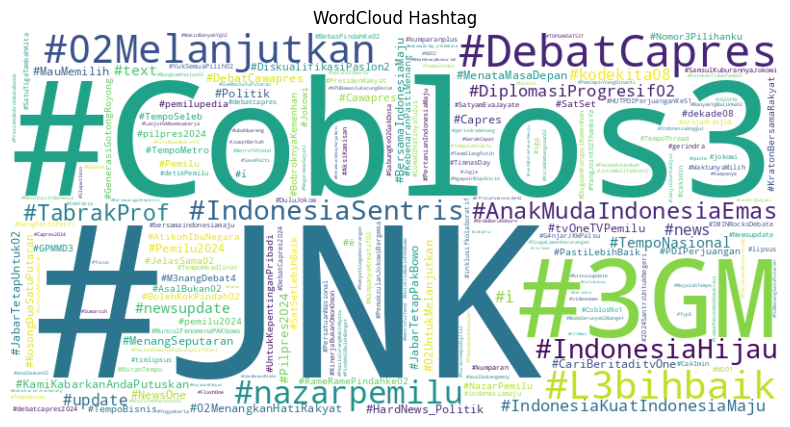

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

hashtag_dict = dict(zip(filtered_df['hashtag'], filtered_df['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtag_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Hashtag')
plt.show()

# Implementasi Preprocessing Prediksi Sentimen

## Ekstraksi Hashtags

In [ ]:
df = pd.read_pickle(folder_path + "/Dataset/dav/result_df_clean.pkl")

In [ ]:
df.columns

Index(['content', 'real_content', 'created_at', 'username', 'tcode',
       'num_retweets', 'frn_cnt', 'flw_cnt', 'sts_cnt', 'loc', 'lst_cnt',
       'lang', 'appearance_count', 'nama_re', 'hashtags', 'content_surya'],
      dtype='object')

In [ ]:
df['hashtags'] = [extract_hashtags(data) for data in df['real_content']]

In [ ]:
df['content_surya'] = [remove_hashtags(data) for data in df['real_content']]

In [ ]:
# df.to_pickle(folder_path + "/Dataset/dav/result_df_clean_surya.pkl")

## Preprocessing teks twit

In [ ]:
df = pd.read_pickle(folder_path + "/Dataset/dav/result_df_clean_surya.pkl")
df.drop(columns='content_tm', axis=1, inplace=True)
df

,content,real_content,created_at,username,tcode,num_retweets,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,lang,appearance_count,nama_re,hashtags,content_surya
0,,@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...,2024-01-31 17:26:28+00:00,@be9+Qm5EsBY7VLxMEGgBlOYaT0KrMsiQQLzN5iG2hOY=,reply,36,696.150781,1543.289555,14114.732016,-,1.757412,id,9411,-,[],@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...
1,!,@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...,2024-01-29 16:57:00+00:00,@JVWxyA2fM/S2B0bN/n/buYbHxNqUC91UUX6ShBzub+I=,reply,0,327.000000,208.666667,11230.333333,-,0.000000,id,3,-,[],@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...
2,! deretan pesohor dan selebriti yang dukung ga...,! Deretan Pesohor dan Selebriti yang Dukung Ga...,2024-01-30 02:03:42+00:00,@7jB3OiFFcymo1DxD4GO8wR2tuWnQLk+nRHfZmLs1iHo=,mention,0,28.000000,2.000000,75.000000,Indonesia,0.000000,id,1,-,"[#GanjarMahfud2024, #Kopassos03, #GanjarPresid...",! Deretan Pesohor dan Selebriti yang Dukung Ga...
3,!! iya pakk salah strategii next nya di perbai...,@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...,2024-01-07 15:57:19+00:00,@CDJsmOeil3IHVzBWFKLBs21n0Q2nBvRird0Wb9yxync=,reply,0,2.000000,2.000000,234.000000,-,0.000000,id,1,-,[],@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...
4,!! katanya sudah dikembalikan oleh !!,@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...,2024-01-19 04:19:17+00:00,@X4DJ8WnurWZZIm9IizCEzcdSPvFwGF1pnHnLk1YMgWk=,reply,0,1347.000000,1390.000000,60962.000000,-,0.000000,id,1,-,[],@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161194,ùùù ùúªùø±ùùùø§ ùùù ùúªùø±ù ø§ùù...,ÙÙÙ ÙÚªÙØ±ÙÙÙØ§ ÙÙÙ ÙÚªÙØ±Ù Ø§ÙÙ...,2024-01-23 19:33:56+00:00,@YlUZ3ZhBsq0qbJW78fvg+NQa9XAwlZc4Td3UlJnX9VM=,reply,0,817.000000,214.000000,804.000000,Semarang Jawa Tengah,0.000000,id,1,-,[],ÙÙÙ ÙÚªÙØ±ÙÙÙØ§ ÙÙÙ ÙÚªÙØ±Ù Ø§ÙÙ...
2161195,ùø§ ø§ùùù ùø§ ø±ø¨ lihatlah pak anies ..p...,@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...,2024-01-05 08:07:21+00:00,@L6SfnSmUwh00lMBvj0JM+1MAFGNyHoDgNsZFTsGSPrg=,reply,0,755.000000,376.000000,6844.000000,-,0.000000,id,1,-,[],@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...
2161196,ùø§ù ùùùùùùø·ùùù ùø§ù ùùùùùù...,ÙØ§Ù ÙÙÙÙÙÙØ·ÙÙÙ ÙØ§Ù ÙÙÙÙÙÙ...,2024-01-28 23:46:18+00:00,@2kSMZAr8Of/TLnCFHP74tuRyrjGH5zTSj8Cg8xVSPd4=,mention,0,21.000000,54.000000,1279.000000,"Riau, Indonesia",0.000000,id,1,-,[],ÙØ§Ù ÙÙÙÙÙÙØ·ÙÙÙ ÙØ§Ù ÙÙÙÙÙÙ...
2161197,ùø±ùø¯ù ø§ùùù øªø¨ø§ø±ù ùøªø¹ø§ùù ù...,@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...,2024-01-21 23:32:46+00:00,@39Pxegm8y2KaJWoGqZHOF05wmueMui4u2yP8EaaK2YM=,reply,0,120.000000,73.000000,791.000000,"Sukasari, Indonesia",0.000000,id,1,-,[],@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...


In [ ]:
df['content_sentiment'] = [remove_rt_re(data) for data in df['content_surya']]
df['content_sentiment'] = [replace_1_2_3(data) for data in df['content_sentiment']]
df['content_sentiment'] = [data.lower() for data in df['content_sentiment']]
df['content_sentiment'] = [unescape_html(data) for data in df['content_sentiment']]
df['content_sentiment'] = [remove_weird_sign(data) for data in df['content_sentiment']]
df['content_sentiment'] = [remove_mention(data) for data in df['content_sentiment']]
df['content_sentiment'] = [remove_links(data) for data in df['content_sentiment']]
df['content_sentiment'] = [kamus_alay_gaul(data) for data in df['content_sentiment']]
df['content_sentiment'] = [remove_double_space(data) for data in df['content_sentiment']]
df['content_sentiment'] = [data.strip() for data in df['content_sentiment']]
df['content_sentiment'].iloc[300]

'" ganjar pranowo saya meminta pendapat bapak tentang undang undang perampasan aset? mahfud hebat buruh naik kelas'

In [ ]:
df.to_pickle(folder_path + "/Dataset_Part2/result_df_clean_sent.pkl")

## Buat Dictionary Hashtag Split

In [ ]:
df = pd.read_pickle(folder_path + "/Dataset_Part2/result_df_clean_sent.pkl")
df['content_sentiment'].iloc[200]

'" ganjar pranowo dorong umkm naik kelas hebat guru mengaji satu juta'

In [ ]:
def split_camel_case(string):
  words = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', string)
  return ' '.join(words)

In [ ]:
hashtag_asli = []
hasil_split = []

for hashtags in df['hashtags']:
  if len(hashtags) != 0:
    for hashtag in hashtags:
      hashtag_asli.append(hashtag)
      hasil_split.append(split_camel_case(hashtag))

print(hashtag_asli[:5])
print(hasil_split[:5])

['#GanjarMahfud2024', '#Kopassos03', '#GanjarPresidenRakyat', '#MahfudPembelaRakyat', '#Anies2ndStage']
['Ganjar Mahfud', 'Kopassos', 'Ganjar Presiden Rakyat', 'Mahfud Pembela Rakyat', 'Anies nd Stage']


In [ ]:
hashtag_split_df = pd.DataFrame(data={'asli': hashtag_asli, 'hasil_split': hasil_split})
hashtag_split_df['lower_case'] = [data.lower() for data in hashtag_split_df['asli']]

In [ ]:
hashtag_split_df['num_splits'] = [len(data) for data in hashtag_split_df['hasil_split']]

In [ ]:
hashtag_split_df.sort_values(by=['lower_case', 'num_splits'], inplace=True, ignore_index=True, ascending=False)

In [ ]:
hashtag_split_df.drop_duplicates(subset='lower_case', inplace=True, keep='first', ignore_index=True)

In [ ]:
hashtag_split_df

,asli,hasil_split,lower_case,num_splits
0,#Ù,,#ù,0
1,#ØºØ²Ù,,#øºø²ù,0
2,#ØµØ,,#øµø,0
3,#Ø²Ø,,#ø²ø,0
4,#Ø,,#ø,0
...,...,...,...,...
22982,#01AMIN,AMIN,#01amin,4
22983,#01AduDomba,Adu Domba,#01adudomba,9
22984,#0103AklamasiPerubahan,Aklamasi Perubahan,#0103aklamasiperubahan,18
22985,#01,,#01,0


In [ ]:
# hashtag_split_df.to_pickle(folder_path + 'Dataset_Part2/df_hashtag_split.pkl')

## Preprocessing Hashtag


---


1. split hashtag berdasarkan dictionary
2. split hashtag dengan fungsi
3. remove indonesia
4. replace hashtag yang mengandung keyword paslon

In [ ]:
hashtag_split_df = pd.read_pickle(folder_path + 'Dataset_Part2/df_hashtag_split.pkl')
hashtag_split_df

,asli,hasil_split,lower_case,num_splits
0,#Ù,,#ù,0
1,#ØºØ²Ù,,#øºø²ù,0
2,#ØµØ,,#øµø,0
3,#Ø²Ø,,#ø²ø,0
4,#Ø,,#ø,0
...,...,...,...,...
22982,#01AMIN,AMIN,#01amin,4
22983,#01AduDomba,Adu Domba,#01adudomba,9
22984,#0103AklamasiPerubahan,Aklamasi Perubahan,#0103aklamasiperubahan,18
22985,#01,,#01,0


In [ ]:
hashtag_split_dict = dict(zip(hashtag_split_df['lower_case'], hashtag_split_df['hasil_split']))

In [ ]:
def split_dictionary(hashtag):
  return hashtag_split_dict[hashtag]

def split_camel_case(hashtag):
  words = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', hashtag)
  return ' '.join(words)

def preprocessing_hashtag_sentiment(hashtag):
  hasil = ''
  try:
    hasil = split_dictionary(hashtag)
  except:
    hasil =  split_camel_case(hashtag)

  return hasil

print('hasil preprocessing:', preprocessing_hashtag_sentiment('#DukungGibranCoblosImin'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#dukunggibrancoblosimin'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#GanjarMahfud2024'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#DavianBENITO'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#L3bihbaik'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#BisaAnies'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#jakartaIndoGanjarnesia'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#indonesiasentris'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#indonesiaSentris'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#IndonesiaSentris'))
print('hasil preprocessing:', preprocessing_hashtag_sentiment('#rakyatmakin'))

hasil preprocessing: Dukung Gibran Coblos Imin
hasil preprocessing: Dukung Gibran Coblos Imin
hasil preprocessing: Ganjar Mahfud
hasil preprocessing: Davian BENITO
hasil preprocessing: bihbaik
hasil preprocessing: Bisa Anies
hasil preprocessing: jakarta Indo Ganjarnesia
hasil preprocessing: Indonesia Sentris
hasil preprocessing: indonesia Sentris
hasil preprocessing: Indonesia Sentris
hasil preprocessing: rakyatmakin


In [ ]:
df['hashtags_clean'] = [[preprocessing_hashtag_sentiment(data) for data in data_list] for data_list in df['hashtags']]
df['hashtags_clean']

0                                                         []
1                                                         []
2          [Ganjar Mahfud, Kopassos, Ganjar Presiden Raky...
3                                                         []
4                                                         []
                                 ...                        
2161194                                                   []
2161195                                                   []
2161196                                                   []
2161197                                                   []
2161198                                                   []
Name: hashtags_clean, Length: 2161199, dtype: object

In [ ]:
df.to_pickle(folder_path + 'Dataset_Part2/result_df_clean_sent.pkl')

# Cek Hasil

In [ ]:
df = pd.read_pickle(folder_path + 'Dataset_Part2/result_df_clean_sent.pkl')
df

,content,real_content,created_at,username,tcode,num_retweets,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,lang,appearance_count,nama_re,hashtags,content_surya,content_sentiment,hashtags_clean
0,,@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...,2024-01-31 17:26:28+00:00,@be9+Qm5EsBY7VLxMEGgBlOYaT0KrMsiQQLzN5iG2hOY=,reply,36,696.150781,1543.289555,14114.732016,-,1.757412,id,9411,-,[],@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...,,[]
1,!,@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...,2024-01-29 16:57:00+00:00,@JVWxyA2fM/S2B0bN/n/buYbHxNqUC91UUX6ShBzub+I=,reply,0,327.000000,208.666667,11230.333333,-,0.000000,id,3,-,[],@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...,!,[]
2,! deretan pesohor dan selebriti yang dukung ga...,! Deretan Pesohor dan Selebriti yang Dukung Ga...,2024-01-30 02:03:42+00:00,@7jB3OiFFcymo1DxD4GO8wR2tuWnQLk+nRHfZmLs1iHo=,mention,0,28.000000,2.000000,75.000000,Indonesia,0.000000,id,1,-,"[#GanjarMahfud2024, #Kopassos03, #GanjarPresid...",! Deretan Pesohor dan Selebriti yang Dukung Ga...,! deretan pesohor dan selebriti yang dukung ga...,"[, Kopassos, Presiden Rakyat, Pembela Rakyat]"
3,!! iya pakk salah strategii next nya di perbai...,@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...,2024-01-07 15:57:19+00:00,@CDJsmOeil3IHVzBWFKLBs21n0Q2nBvRird0Wb9yxync=,reply,0,2.000000,2.000000,234.000000,-,0.000000,id,1,-,[],@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...,!! iya pakk salah strategii next nya di perbai...,[]
4,!! katanya sudah dikembalikan oleh !!,@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...,2024-01-19 04:19:17+00:00,@X4DJ8WnurWZZIm9IizCEzcdSPvFwGF1pnHnLk1YMgWk=,reply,0,1347.000000,1390.000000,60962.000000,-,0.000000,id,1,-,[],@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...,!! katanya sudah dikembalikan oleh !!,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161194,ùùù ùúªùø±ùùùø§ ùùù ùúªùø±ù ø§ùù...,ÙÙÙ ÙÚªÙØ±ÙÙÙØ§ ÙÙÙ ÙÚªÙØ±Ù Ø§ÙÙ...,2024-01-23 19:33:56+00:00,@YlUZ3ZhBsq0qbJW78fvg+NQa9XAwlZc4Td3UlJnX9VM=,reply,0,817.000000,214.000000,804.000000,Semarang Jawa Tengah,0.000000,id,1,-,[],ÙÙÙ ÙÚªÙØ±ÙÙÙØ§ ÙÙÙ ÙÚªÙØ±Ù Ø§ÙÙ...,dan mereka (orang-orang kafir) membuat tipu da...,[]
2161195,ùø§ ø§ùùù ùø§ ø±ø¨ lihatlah pak anies ..p...,@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...,2024-01-05 08:07:21+00:00,@L6SfnSmUwh00lMBvj0JM+1MAFGNyHoDgNsZFTsGSPrg=,reply,0,755.000000,376.000000,6844.000000,-,0.000000,id,1,-,[],@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...,lihatlah pak anies ..pendukungnya nya sudah en...,[]
2161196,ùø§ù ùùùùùùø·ùùù ùø§ù ùùùùùù...,ÙØ§Ù ÙÙÙÙÙÙØ·ÙÙÙ ÙØ§Ù ÙÙÙÙÙÙ...,2024-01-28 23:46:18+00:00,@2kSMZAr8Of/TLnCFHP74tuRyrjGH5zTSj8Cg8xVSPd4=,mention,0,21.000000,54.000000,1279.000000,"Riau, Indonesia",0.000000,id,1,-,[],ÙØ§Ù ÙÙÙÙÙÙØ·ÙÙÙ ÙØ§Ù ÙÙÙÙÙÙ...,. 2024 indonesia maju bpk. anies-muhaimin,[]
2161197,ùø±ùø¯ù ø§ùùù øªø¨ø§ø±ù ùøªø¹ø§ùù ù...,@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...,2024-01-21 23:32:46+00:00,@39Pxegm8y2KaJWoGqZHOF05wmueMui4u2yP8EaaK2YM=,reply,0,120.000000,73.000000,791.000000,"Sukasari, Indonesia",0.000000,id,1,-,[],@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...,""":",[]


In [15]:
df = pd.read_pickle(folder_path + 'Dataset_Part2/result_df_clean_tm.pkl')
df

,content,real_content,created_at,username,tcode,num_retweets,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,lang,appearance_count,nama_re,hashtags,content_surya,content_tm,hashtags_clean,content_tm_rm_stopwords_last
0,,@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...,2024-01-31 17:26:28+00:00,@be9+Qm5EsBY7VLxMEGgBlOYaT0KrMsiQQLzN5iG2hOY=,reply,36,696.150781,1543.289555,14114.732016,-,1.757412,id,9411,-,[],@X3PdsT0s+nosDiSVDq3nQPNxLKQV1ZMBl5NDSXLLnOs= ...,,[],
1,!,@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...,2024-01-29 16:57:00+00:00,@JVWxyA2fM/S2B0bN/n/buYbHxNqUC91UUX6ShBzub+I=,reply,0,327.000000,208.666667,11230.333333,-,0.000000,id,3,-,[],@9ZwcLHT18/fgudsdN9vmg9J97LmX6RgmUQ41zZwq484= ...,,[],
2,! deretan pesohor dan selebriti yang dukung ga...,! Deretan Pesohor dan Selebriti yang Dukung Ga...,2024-01-30 02:03:42+00:00,@7jB3OiFFcymo1DxD4GO8wR2tuWnQLk+nRHfZmLs1iHo=,mention,0,28.000000,2.000000,75.000000,Indonesia,0.000000,id,1,-,"[#GanjarMahfud2024, #Kopassos03, #GanjarPresid...",! Deretan Pesohor dan Selebriti yang Dukung Ga...,deretan pesohor selebriti dukung pilihan ganja...,"[, Kopassos, , ]",deretan pesohor selebriti pilihan satset tastes
3,!! iya pakk salah strategii next nya di perbai...,@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...,2024-01-07 15:57:19+00:00,@CDJsmOeil3IHVzBWFKLBs21n0Q2nBvRird0Wb9yxync=,reply,0,2.000000,2.000000,234.000000,-,0.000000,id,1,-,[],@04DvPx8s7LBc4cxDKmtXMRGxzcWjux55XJYA4DJpUOQ= ...,iya pakk salah strategii next nya perbaika seb...,[],pakk salah strategii next perbaika sebanding
4,!! katanya sudah dikembalikan oleh !!,@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...,2024-01-19 04:19:17+00:00,@X4DJ8WnurWZZIm9IizCEzcdSPvFwGF1pnHnLk1YMgWk=,reply,0,1347.000000,1390.000000,60962.000000,-,0.000000,id,1,-,[],@YKXM72NPxrEQof3YA3UvtB1N7433ER/5HCHcbEdjJi8= ...,dikembalikan,[],dikembalikan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161194,ùùù ùúªùø±ùùùø§ ùùù ùúªùø±ù ø§ùù...,ÙÙÙ ÙÚªÙØ±ÙÙÙØ§ ÙÙÙ ÙÚªÙØ±Ù Ø§ÙÙ...,2024-01-23 19:33:56+00:00,@YlUZ3ZhBsq0qbJW78fvg+NQa9XAwlZc4Td3UlJnX9VM=,reply,0,817.000000,214.000000,804.000000,Semarang Jawa Tengah,0.000000,id,1,-,[],ÙÙÙ ÙÚªÙØ±ÙÙÙØ§ ÙÙÙ ÙÚªÙØ±Ù Ø§ÙÙ...,orang orang kafir tipu daya allah membalas tip...,[],kafir tipu daya allah membalas tipu daya all...
2161195,ùø§ ø§ùùù ùø§ ø±ø¨ lihatlah pak anies ..p...,@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...,2024-01-05 08:07:21+00:00,@L6SfnSmUwh00lMBvj0JM+1MAFGNyHoDgNsZFTsGSPrg=,reply,0,755.000000,376.000000,6844.000000,-,0.000000,id,1,-,[],@4uY/ZdECIddb7Nic17AVwJvAOMYdB6FA2V9bUbDB4LE= ...,lihatlah pendukungnya nya kuat rezim joko berk...,[],lihatlah kuat rezim joko berkuasa kesengsara...
2161196,ùø§ù ùùùùùùø·ùùù ùø§ù ùùùùùù...,ÙØ§Ù ÙÙÙÙÙÙØ·ÙÙÙ ÙØ§Ù ÙÙÙÙÙÙ...,2024-01-28 23:46:18+00:00,@2kSMZAr8Of/TLnCFHP74tuRyrjGH5zTSj8Cg8xVSPd4=,mention,0,21.000000,54.000000,1279.000000,"Riau, Indonesia",0.000000,id,1,-,[],ÙØ§Ù ÙÙÙÙÙÙØ·ÙÙÙ ÙØ§Ù ÙÙÙÙÙÙ...,maju bpk,[],maju bpk
2161197,ùø±ùø¯ù ø§ùùù øªø¨ø§ø±ù ùøªø¹ø§ùù ù...,@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...,2024-01-21 23:32:46+00:00,@39Pxegm8y2KaJWoGqZHOF05wmueMui4u2yP8EaaK2YM=,reply,0,120.000000,73.000000,791.000000,"Sukasari, Indonesia",0.000000,id,1,-,[],@GZMEjTAgvDMOgE/eyq6dkYIbNfMI2fVEyWe3APOdUDU= ...,,[],


In [ ]:
df['content_surya'].iloc[2994]

'"Dia ngerti enggak ada HGU, hak guna usaha, hak guna bangunan, hak pakai. Itu tanah negara saudara, tanah rakyat, tanah bangsa. Drpd dikuasai asing, lebih baik Prabowo yg kelola."   Menhan Prabow Gaza 14FebKeTPS YesPAKBowo KitaMASBOWO DanGBRAN   https://t.co/s2DJh2S49a'

In [ ]:
df['real_content'].iloc[2994]

'"Dia ngerti enggak ada HGU, hak guna usaha, hak guna bangunan, hak pakai. Itu tanah negara saudara, tanah rakyat, tanah bangsa. Drpd dikuasai asing, lebih baik Prabowo yg kelola." #airlanggacenter Menhan Prabow Gaza 14FebKeTPS YesPAKBowo KitaMASBOWO DanGBRAN #MudaSerunya02Banget https://t.co/s2DJh2S49a'

In [ ]:
df['content_tm'].iloc[2994]

'mengerti hgu hak usaha hak bangunan hak pakai tanah negara saudara tanah rakyat tanah bangsa dikuasai asing kelola menhan prabow gaza febketps yespakbowo kitamasbowo dangbran'

In [ ]:
for idx, data in enumerate(df['content_tm']):
  if 'kitamasbowo' in data.lower():
    print(idx)
    print(data)
    break

2994
mengerti hgu hak usaha hak bangunan hak pakai tanah negara saudara tanah rakyat tanah bangsa dikuasai asing kelola menhan prabow gaza febketps yespakbowo kitamasbowo dangbran


# Contoh Prep untuk paper

In [33]:
example = 'RT pemilu bukan hanya tentang memilih, tapi juga tentang memilih yang terbaik bersama jnk &amp; ganjar pranowo mahfud md. Â jn19v5 #jnk #ganjarmahfudrebound #ganjarpranowopilihanumat @0FdbcMXvQjETOi9bqnSH4e8mcVM6salfFYRhhtnQ0xQ= https://t.co/b2InuP5Dym ð\x9f\x9b¤ [RE rebekahsau64515]'
example

'RT pemilu bukan hanya tentang memilih, tapi juga tentang memilih yang terbaik bersama jnk &amp; ganjar pranowo mahfud md. Â jn19v5 #jnk #ganjarmahfudrebound #ganjarpranowopilihanumat @0FdbcMXvQjETOi9bqnSH4e8mcVM6salfFYRhhtnQ0xQ= https://t.co/b2InuP5Dym ð\x9f\x9b¤ [RE rebekahsau64515]'

In [27]:
res = example.lower()
res

'rt pemilu bukan hanya tentang memilih, tapi juga tentang memilih yang terbaik bersama jnk &amp; ganjar pranowo mahfud md. â jn19v5 #jnk #ganjarmahfudrebound #ganjarpranowopilihanumat @0fdbcmxvqjetoi9bqnsh4e8mcvm6salffyrhhtnq0xq= https://t.co/b2inup5dym ð\x9f\x9b¤ [re rebekahsau64515]'

In [34]:
res = remove_rt_re(example)
res = remove_mention(res)
res = remove_links(res)
res = res.lower()
res

'pemilu bukan hanya tentang memilih, tapi juga tentang memilih yang terbaik bersama jnk &amp; ganjar pranowo mahfud md. â jn19v5 #jnk #ganjarmahfudrebound #ganjarpranowopilihanumat     ð\x9f\x9b¤'

In [35]:
res = unescape_html(res)
res

'pemilu bukan hanya tentang memilih, tapi juga tentang memilih yang terbaik bersama jnk & ganjar pranowo mahfud md. â jn19v5 #jnk #ganjarmahfudrebound #ganjarpranowopilihanumat     ð\x9f\x9b¤'

In [36]:
res = remove_weird_sign(res)
res

'pemilu bukan hanya tentang memilih, tapi juga tentang memilih yang terbaik bersama jnk & ganjar pranowo mahfud md.  jn19v5 #jnk #ganjarmahfudrebound #ganjarpranowopilihanumat     '

In [37]:
res = kamus_alay_gaul(res)
res

'pemilu bukan hanya tentang memilih, tapi juga tentang memilih yang terbaik bersama jnk & ganjar pranowo mahfud md.  jn19v5 #jnk #ganjarmahfudrebound #ganjarpranowopilihanumat     '

In [38]:
res = remove_hashtags(res)
res = remove_punctuation(res)
res = remove_digits(res)
res

'pemilu bukan hanya tentang memilih  tapi juga tentang memilih yang terbaik bersama jnk   ganjar pranowo mahfud md   jnv           '

In [40]:
res = remove_stopwords_all(res)
res = remove_double_space(res)
res.strip()

'pemilu memilih memilih jnk jnv'

In [42]:
hashtag_paslon1_manual = pd.read_excel(folder_path + 'Dataset_Part2/keyterms_paslon/hashtag_paslon1.xlsx')
hashtag_paslon1_manual = hashtag_paslon1_manual.head(200)

hashtag_paslon1_positif = hashtag_paslon1_manual[hashtag_paslon1_manual['Label'].isna()]
print(', '.join(hashtag_paslon1_positif['hashtag']))

Unnamed: 0, hashtag, count, Label


In [ ]:
hashtag_paslon1_positif

,Unnamed: 0,hashtag,count,Label
0,0,#AMINAjaDulu,398879,NaN
1,1,#AniesMuhaimin2024,134312,NaN
2,2,#DesakAnies,85963,NaN
3,3,#HaveAniesDay,70925,NaN
4,4,#PahitManiesAlwaysWithAnies,70448,NaN
...,...,...,...,...
194,194,#DukungGibranCoblosImin,139,NaN
195,195,#AnieMuhaimin2024,139,NaN
196,196,#Anies2ndstage,134,NaN
197,197,#AminMenangJudolHilang,132,NaN
